<a href="https://colab.research.google.com/github/anas-awadalla/Incepto/blob/master/interpretability_experiments/mPower_Interpretability_Attribution_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from torchray.utils import get_device
from torchray.attribution.extremal_perturbation import contrastive_reward
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

In [2]:
device = torch.device('cuda:0')

In [3]:
from parkinsonsNet import Network
model = torch.load("/home/anasa2/Incepto/pre_trained/parkinsonsNet-rest_mpower-rest.pth")
print(model)

Network(
  (conv1): Sequential(
    (0): Conv1d(3, 8, kernel_size=(5,), stride=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(6,), stride=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv1d(32, 32, kernel_size=(6,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

In [4]:
trans = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()])

trans_color = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.ToTensor()])

In [5]:
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import math
import json
import time
from matplotlib.pylab import plt
%matplotlib inline 
import itertools

class testMotionData(Dataset):

    def __init__(self, df, users, root_dir = '/home/jupyter/park/', transform=None):
      
        self.dataset = df
        self.root_dir = root_dir
        self.dataArray = []
        self.resultArray = []
        iterData = iter(self.dataset.iterrows())

        k = 0

        for j,z in zip(iterData,tqdm(range(int(len(self.dataset))))):
#           gc.collect()
#           gc.collect()
          j = j[1]
          healthcode = j[3]
        
          label = users.loc[healthcode][0]
          
          #print(j)
          for i in [8]:
            if(not math.isnan(j[i])):
                filedir = str(int(j[i]/10000))
                filename = str(j[i])
                length = len(filename)
                filename = filename[0:length-2]

                if(os.path.isfile(self.root_dir+filedir+"/"+filename+".json"))|(os.path.isfile(self.root_dir+"data"+"/"+filename+".json")):
                  if(os.path.isfile(self.root_dir+filedir+"/"+filename+".json")):
                    f = open(self.root_dir+filedir+"/"+filename+".json")
                  else:
                    f = open(self.root_dir+"data/"+filename+".json")
                try:
                    data = json.load(f)
                except:
                    continue
                self.dataArray.append([])
                self.dataArray[k].append([])
                self.dataArray[k].append([])
                self.dataArray[k].append([])
                for i in range(0,len(data),2):
                      x = data[i].get("rotationRate")
#                       print(i)
                      self.dataArray[k][0].append(x["x"])
                      self.dataArray[k][1].append(x["y"])
                      self.dataArray[k][2].append(x["z"])
            
                stdev = np.std(np.asarray(self.dataArray[k]))
                mean = np.mean(np.asarray(self.dataArray[k]))
                self.dataArray[k] = ((np.asarray(self.dataArray[k])-mean)/stdev).tolist()
                        
                self.dataArray[k][0] = correct_batch(self.dataArray[k][0])
                self.dataArray[k][1] = correct_batch(self.dataArray[k][1])
                self.dataArray[k][2] = correct_batch(self.dataArray[k][2])
                
                
                

                if(label):
                  self.resultArray.append(1)
                else:
                  self.resultArray.append(0)
                
#                 plt.plot(self.dataArray[k][0],label="X")
#                 plt.plot(self.dataArray[k][1],label="Y")
#                 plt.plot(self.dataArray[k][2],label="Z")
#                 plt.suptitle(label)
#                 plt.legend(loc="upper left")
#                 plt.show()
#                 time.sleep(0.5)
                

                k = k + 1



        self.dataArray = np.asarray(self.dataArray)
        unique, counts = np.unique(np.array(self.resultArray), return_counts=True)
        print(dict(zip(unique, counts)))



    def __len__(self):
        return len(self.resultArray)

    def __getitem__(self, idx):
        sample = {'data': self.dataArray[idx], 'result': self.resultArray[idx]}

        return sample

## Find Masks

In [28]:
from torchvision.utils import save_image
import os
import pandas as pd
from signal_purtubation import extremal_perturbation


masked = []
model.to(device).eval()
model = model.float()
area = 0.1

dataloader = torch.load("/home/anasa2/Incepto/originalParkinsonsDataloaders/val_loader.pth")
for i in tqdm(dataloader):  
  dta = i.get("data")
  dta = dta.to(device)
  labels = i.get("result")
  for x,y in zip(dta,labels):
    if y.item() == 0:
      # Extremal perturbation
      x = torch.FloatTensor(x.unsqueeze(0).unsqueeze(3).cpu().float()).to(device)
      masks_1,_ = extremal_perturbation(
          model, x, y.item(),
          reward_func=contrastive_reward,
          perturbation="blur",
          debug=False,
          areas=[area],
          smooth=0.01,
          max_iter=800
      )

      ## Crop Important Area
      dat=torch.round(masks_1)[0].cpu().detach().numpy() # 'sharpen' mask
      true_points = np.argwhere(dat)
      if len(true_points) != 0:
        # take the smallest points and use them as the top left of your crop
        top_left = true_points.min(axis=0)
        # take the largest points and use them as the bottom right of your crop
        bottom_right = true_points.max(axis=0)
        x = x.squeeze(3)
        print(x.shape)
        out = x[:, 
                  :,top_left[1]:bottom_right[1]]
        out =  torch.tensor(out, dtype=torch.float)
        print(out.shape)

        masked.append(out)
      

[  0 538   0]
[   0 1519    0]
torch.Size([1, 3, 4000])
torch.Size([1, 3, 981])
[  0 272   0]
[   0 1471    0]
torch.Size([1, 3, 4000])
torch.Size([1, 3, 1199])
[  0 231   0]
[   0 1281    0]
torch.Size([1, 3, 4000])
torch.Size([1, 3, 1050])



KeyboardInterrupt: 

## Cluster Representations

In [19]:
orginal_signal = []
results = []
for i in tqdm(range(len(masked))):
  orginal_signal.append((masked[i]).cpu().detach().numpy())
  results.append(torch.flatten((masked[i]), start_dim=0).cpu().detach().numpy())
X1 = torch.flatten(torch.tensor(results), start_dim=1).cpu().detach().numpy()

tensor([], size=(0, 3, 982))
tensor([], size=(0, 3, 1199))
tensor([], size=(0, 3, 1107))
tensor([], size=(0, 3, 1309))
tensor([], size=(0, 3, 1262))
tensor([], size=(0, 3, 1325))
tensor([], size=(0, 3, 1283))
tensor([], size=(0, 3, 1108))
tensor([], size=(0, 3, 1444))
tensor([], size=(0, 3, 1486))
tensor([], size=(0, 3, 1219))
tensor([], size=(0, 3, 1072))
tensor([], size=(0, 3, 1402))
tensor([], size=(0, 3, 1311))
tensor([], size=(0, 3, 1409))
tensor([], size=(0, 3, 1178))
tensor([], size=(0, 3, 554))
tensor([], size=(0, 3, 1176))
tensor([], size=(0, 3, 1171))
tensor([], size=(0, 3, 1108))
tensor([], size=(0, 3, 1233))
tensor([], size=(0, 3, 1478))
tensor([], size=(0, 3, 1247))
tensor([], size=(0, 3, 1353))
tensor([], size=(0, 3, 1178))
tensor([], size=(0, 3, 1150))
tensor([], size=(0, 3, 1233))
tensor([], size=(0, 3, 1036))
tensor([], size=(0, 3, 1128))



In [12]:
#Sanity check
X = X1
print ("The shape of X is " + str(X.shape))

The shape of X is (18, 0)


In [13]:
# To perform PCA we must first change the mean to 0 and variance to 1 for X using StandardScalar
Clus_dataSet = StandardScaler().fit_transform(X) #(mean = 0 and variance = 1)

ValueError: Found array with 0 feature(s) (shape=(18, 0)) while a minimum of 1 is required by StandardScaler.

In [ ]:
from sklearn.decomposition import PCA
# Make an instance of the Model
variance = 0.
pca = PCA(variance)

In [ ]:
#fit the data according to our PCA instance
pca.fit(Clus_dataSet)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
print("Number of components before PCA  = " + str(X.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_))

Number of components before PCA  = 50176
Number of components after PCA 0.98 = 2


In [ ]:
#Transform our data according to our PCA instance
Clus_dataSet = pca.transform(Clus_dataSet)

In [ ]:
print("Dimension of our data after PCA  = " + str(Clus_dataSet.shape))

Dimension of our data after PCA  = (55, 2)


In [ ]:
#To visualise the data inversed from PCA
approximation = pca.inverse_transform(Clus_dataSet)
print("Dimension of our data after inverse transforming the PCA  = " + str(approximation.shape))

In [ ]:
from sklearn.metrics import silhouette_score

sil = []

ideal = None
max = float('-inf')
x = Clus_dataSet

for k in range(2,3):
  kmeans = KMeans(init = "k-means++",n_clusters = k, n_init = 35, max_iter=1000).fit(x)
  labels = kmeans.labels_
  score = silhouette_score(x, labels, metric = 'euclidean')
  if(score > max):
    max = score
    ideal = kmeans

In [ ]:
k_means = ideal
print(k_means)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=2, n_init=35, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


In [ ]:
k_means_labels = k_means.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))

The list of labels of the clusters are [0 1]


In [ ]:
k_means_cluster_centers = k_means.cluster_centers_ #numpy array of cluster centers
k_means_cluster_centers.shape #comes from 10 clusters and 420 features

(2, 50176)

In [ ]:
k_means.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [ ]:
#Find average "image" for each cluster
clusters = {}
for i,j in zip(k_means.labels_,color) :
  if i in clusters.keys():
    clusters.get(i).append(j)
    # clusters.update({i:clusters.get(i).append(j)})
  else:
    clusters.update({i:[j]})

## Use Chi^2 Similarity for Comparisons

In [ ]:
import cv2

def get_similar(arr):
  chosen = arr[0]
  x = {}
  for i in range(len(arr)):
    x.update({i: cv2.compareHist(np.array(chosen, dtype=np.float32), np.array(arr[i], dtype=np.float32), 2)})
  x = {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
  return (x.keys())
    


In [ ]:
def choose_sim(arr,target,ratio):
  threshold = int(len(arr)*ratio)
  arr = arr[threshold:]
  result = []
  for i in range(len(target)):
    if(i in arr):
      result.append(target[i])
    
  return result

## Find visualization by individual pixel comparisons

In [ ]:
def get_representation(arr):
  li = []
  for i in range(224):
    li.append([])
    for j in range(224):
      dist = {0:0,1:0}
      for img in arr:
        pixel = img[0][i][j]
        if pixel > 0:
          pixel = 1
        else:
          pixel = 0
        dist.update({pixel:dist.get(pixel)+1})
      if(dist.get(0)>dist.get(1)):
        li[i].append(0)
      else:
        li[i].append(1)
  return li



## Visualize Results

224 224
224 224


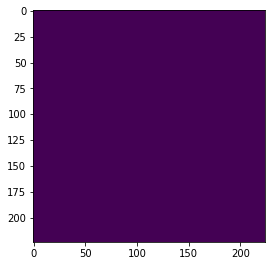

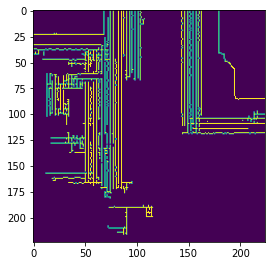

In [ ]:
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2

i = 0
for key in clusters.keys():
  fig = plt.figure(figsize=(40,40))    
  ax = fig.add_subplot(8, 8, i + 1)
  arr = get_similar(clusters.get(key))
  arr = choose_sim(list(arr),clusters.get(key),0)
  arr = sum(arr)/len(arr)
  img = torch.tensor(arr).cpu().squeeze().detach().numpy()
  ax.plt(img[0])
  ax.plt(img[1])
  ax.plt(img[2])
  i += 1
plt.show()
